# Partisan Symmetry Measures

This notebook explores some of the standard partisan symmetry measures on the state of Pennsylvania using election data from the last cycle. 


In [1]:
import matplotlib.pyplot as plt

import networkx as nx

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, partisan_bias

import geopandas as gpd

import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

from gerrychain.updaters import cut_edges

from gerrychain.tree import bipartition_tree, find_balanced_edge_cuts_memoization

#import maup

import numpy as np

import pandas as pd

import geopandas as gpd

import random


In [2]:
graph = Graph.from_json("./Dual_Graphs/PA_Plans.json")

In [3]:
graph.nodes()[0]

{'boundary_node': True,
 'boundary_perim': 7009.142669754194,
 'area': 40058229.21596653,
 'STATEFP10': '42',
 'COUNTYFP10': '085',
 'VTDST10': '960',
 'GEOID10': '42085960',
 'VTDI10': 'A',
 'NAME10': 'SHENANGO TWP VTD WEST',
 'NAMELSAD10': 'SHENANGO TWP VTD WEST',
 'LSAD10': '00',
 'MTFCC10': 'G5240',
 'FUNCSTAT10': 'N',
 'ALAND10': 39740056,
 'AWATER10': 141805,
 'INTPTLAT10': '+41.1564874',
 'INTPTLON10': '-080.4865792',
 'TOTPOP': 1915,
 'NH_WHITE': 1839,
 'NH_BLACK': 35,
 'NH_AMIN': 1,
 'NH_ASIAN': 8,
 'NH_NHPI': 0,
 'NH_OTHER': 3,
 'NH_2MORE': 19,
 'HISP': 10,
 'H_WHITE': 3,
 'H_BLACK': 0,
 'H_AMIN': 1,
 'H_ASIAN': 0,
 'H_NHPI': 0,
 'H_OTHER': 4,
 'H_2MORE': 2,
 'VAP': 1553,
 'HVAP': 7,
 'WVAP': 1494,
 'BVAP': 30,
 'AMINVAP': 1,
 'ASIANVAP': 6,
 'NHPIVAP': 0,
 'OTHERVAP': 2,
 '2MOREVAP': 13,
 'ATG12D': 514.0001036045286,
 'ATG12R': 388.0000782073095,
 'GOV10D': 289.00005825235166,
 'GOV10R': 349.00007034626555,
 'PRES12D': 492.0000991700935,
 'PRES12O': 11.000002217217538,
 'PRE

In [4]:
updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "PP":polsby_popper
}


num_elections = 9

election_names = [
    "PRES12",
    "PRES16",
    "SEN16",
    "SEN12",
    "SEN10",
    "GOV14",
    "GOV10",
    "ATG16",
    "ATG12"
]

election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["USS12D", "USS12R"],
    ["SEN10D", "SEN10R"],
    ["GOV14D","GOV14R"],
    ["GOV10D","GOV10R"],
    ["T16ATGD","T16ATGR"],
    ["ATG12D","ATG12R"]
]


elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)



In [5]:
#Create Real Plan Partitions
n_base_plans = 7


partition_2011 = GeographicPartition(graph, "CD_2011", updaters)
partition_GOV = GeographicPartition(graph, "GOV", updaters)
partition_TS = GeographicPartition(graph, "TS", updaters)
partition_REMEDIAL = GeographicPartition(graph, "REMEDIAL", updaters)
partition_CPCT = GeographicPartition(graph, "538CMPCT", updaters)
partition_DEM = GeographicPartition(graph, "538DEM", updaters)
partition_GOP = GeographicPartition(graph, "538GOP", updaters)



proposed_plans = [partition_2011,partition_GOV,partition_TS,partition_REMEDIAL,
                 partition_CPCT,partition_DEM,partition_GOP]
plan_names = ['2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT', 'DEM', 'GOP']

clist = ['red','blue','hotpink','purple','green','slate','darkred']

In [6]:
sorted(partition_2011["GOV14"].percents("Democratic"))

[0.41386377263184476,
 0.44318400642387157,
 0.44496808591103965,
 0.4587490893274038,
 0.45971640431178423,
 0.46184009477678417,
 0.4666279367190656,
 0.47102291432798976,
 0.4835518977268542,
 0.49665220514854563,
 0.5127530685424189,
 0.5152913861827337,
 0.5167155004062131,
 0.6093848547850276,
 0.695779368851982,
 0.698092313045561,
 0.8397645942063242,
 0.9176574185703148]

In [7]:
for election in election_names:
    print(election)
    print("DEM %:",round(proposed_plans[0][election].percent("Democratic"),3))

    for i in range(len(proposed_plans)):

        
        print(plan_names[i],proposed_plans[i][election].wins("Democratic"))
        print(plan_names[i],round(mean_median(proposed_plans[i][election]),3))
        print(plan_names[i],round(partisan_bias(proposed_plans[i][election]),3))
        print(plan_names[i],round(efficiency_gap(proposed_plans[i][election]),3))
        
        


PRES12
DEM %: 0.527
2011 5
2011 -0.045
2011 -0.222
2011 -0.273
GOV 7
GOV -0.032
GOV -0.111
GOV -0.158
TS 8
TS -0.047
TS -0.167
TS -0.089
REMEDIAL 9
REMEDIAL -0.028
REMEDIAL -0.111
REMEDIAL -0.033
CPCT 8
CPCT -0.028
CPCT -0.111
CPCT -0.089
DEM 10
DEM 0.015
DEM 0.0
DEM 0.022
GOP 6
GOP -0.058
GOP -0.222
GOP -0.208
PRES16
DEM %: 0.496
2011 6
2011 -0.038
2011 -0.111
2011 -0.143
GOV 7
GOV -0.045
GOV -0.056
GOV -0.09
TS 6
TS -0.045
TS -0.167
TS -0.136
REMEDIAL 8
REMEDIAL -0.02
REMEDIAL -0.056
REMEDIAL -0.026
CPCT 7
CPCT -0.053
CPCT -0.111
CPCT -0.082
DEM 9
DEM 0.017
DEM 0.056
DEM 0.024
GOP 5
GOP -0.065
GOP -0.222
GOP -0.204
SEN16
DEM %: 0.493
2011 4
2011 -0.043
2011 -0.222
2011 -0.259
GOV 7
GOV -0.035
GOV -0.111
GOV -0.094
TS 4
TS -0.046
TS -0.222
TS -0.257
REMEDIAL 5
REMEDIAL -0.009
REMEDIAL -0.056
REMEDIAL -0.192
CPCT 5
CPCT -0.048
CPCT -0.167
CPCT -0.189
DEM 9
DEM 0.02
DEM 0.0
DEM 0.033
GOP 5
GOP -0.055
GOP -0.222
GOP -0.195
SEN12
DEM %: 0.546
2011 9
2011 -0.052
2011 -0.222
2011 -0.071
GOV

In [8]:
round(mean_median(proposed_plans[0]['PRES12']),3)

-0.045

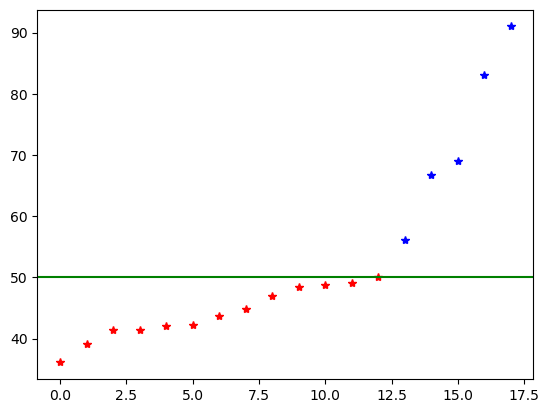

In [9]:
plt.plot(list(range(13)),[100*round(x,3) for x in sorted(proposed_plans[0]['PRES12'].percents("Democratic")) if x<.5], '*',color='red')
plt.plot([13,14,15,16,17],[100*round(x,3) for x in sorted(proposed_plans[0]['PRES12'].percents("Democratic")) if x>.5], '*',color='blue')
plt.axhline(50,color='green')



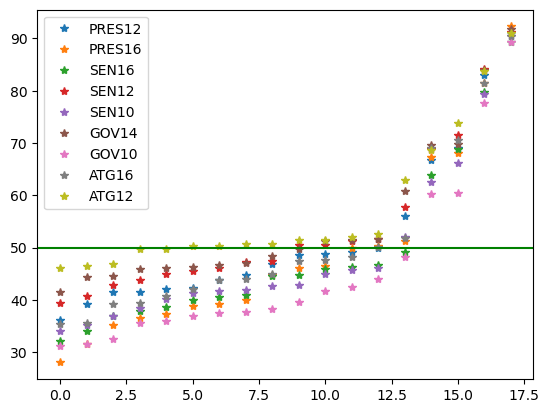

In [10]:
for election in election_names:

    plt.plot([100*round(x,3) for x in sorted(proposed_plans[0][election].percents("Democratic"))], '*',label=election)
plt.axhline(50,color='green')
plt.legend()


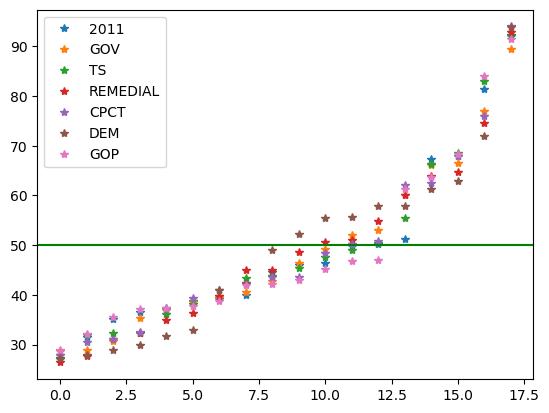

In [11]:
for i in range(7):

    plt.plot([100*round(x,3) for x in sorted(proposed_plans[i]['PRES16'].percents("Democratic"))], '*',label=plan_names[i])
plt.axhline(50,color='green')
plt.legend()


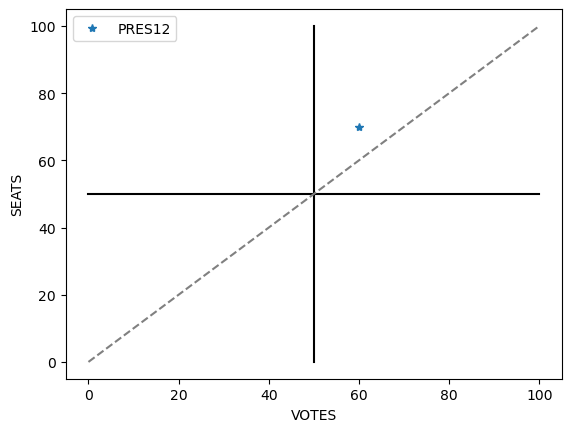

In [12]:
plt.plot([0,100],[50,50],color='k')
plt.plot([50,50],[0,100],color='k')
plt.plot([0,100],[0,100],'--',color='grey')
plt.plot([59.9],[70],'*',label='PRES12')
plt.xlabel('VOTES')
plt.ylabel('SEATS')

plt.legend()

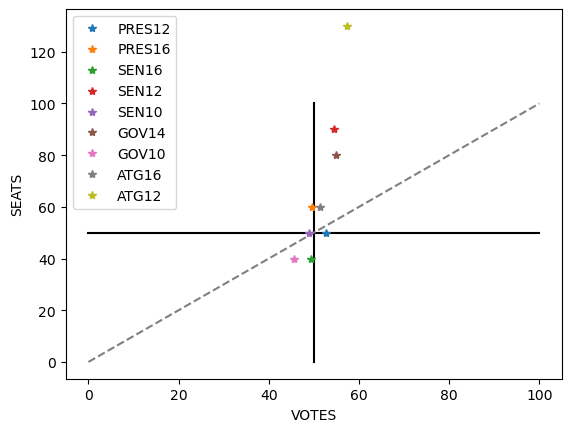

In [13]:
plt.plot([0,100],[50,50],color='k')
plt.plot([50,50],[0,100],color='k')
plt.plot([0,100],[0,100],'--',color='grey')
for election in election_names:
    plt.plot([100*proposed_plans[0][election].percent("Democratic")],[10*proposed_plans[0][election].wins("Democratic")],'*',label=election)
plt.xlabel('VOTES')
plt.ylabel('SEATS')

plt.legend()

**Assignment** The plots above mostly just make comparisons for the first proposed plan. What happens when you vary the underlying map or election?

In [14]:
plan_partitions = proposed_plans
plan_part_labels = plan_names
enames = election_names

In [15]:
#Helper functions
def plot_symmetry_with_mean_overhaul_rb(pvec,mean,xl=0,xu=1,yl=0,yu=1):
    
    n=5000
    l=len(pvec)
    pvec = np.array(sorted(pvec))
    seats = []
    votes = []
    small = pvec[0]
    large = pvec[-1]
    
    gap = large - small
    
    
    
    #mean = np.mean(pvec)
    
    lvec = pvec - mean*np.ones([1,l])
    
    
    
    for t in range(n):
        tvec = lvec + (t/n)*np.ones([1,l])
        votes.append(t/n)#votes.append(np.mean(tvec))
        seats.append(sum(sum(tvec>=.5))/l)
        
    
 
    #print(lvec,tvec,seats[400])
    
    plt.figure(figsize=(8,8) )   
    plt.plot(votes,seats,linewidth = 3,color='r')
    plt.axhline(.5,color='gray')
    plt.axvline(.5,color='gray')

    #plt.plot([.5],[.5],'ro', markersize=10)
    plt.plot([mean],[sum(pvec>=.5)/l],'r*', markersize=20)

    plt.xlabel("Dem Vote %")
    plt.ylabel("Dem Seat %")
    #plt.xticks(bn,cn, rotation=45)
    ys=[x/l for x in range(l+1)]
    zs=[str(round(float(ys), 3)) for ys in ys]
    #plt.yticks(ys,zs)
    
    plt.xlim([xl,xu])
    plt.ylim([yl,yu])

    plt.title("Seats -- Votes")
    
    

    plt.show()
    
    fvotes = [1-x for x in votes]
    fseats = [1-x for x in seats]
    
    plt.figure(figsize=(8,8) )   
    plt.plot(votes,seats,linewidth = 1,color='blue')
    plt.plot(fvotes,fseats,linewidth = 1,color='red')
    plt.axhline(.5,color='gray')
    plt.axvline(.5,color='gray')
    plt.fill_between(votes,seats,list(reversed(fseats)),color='gray')

    #plt.plot([.5],[.5],'ro', markersize=10)
    #plt.plot([mean],[sum(pvec>=.5)/l],'g*', markersize=10)

    plt.xlabel("Dem Vote %")
    plt.ylabel("Dem Seat %")
    #plt.xticks(bn,cn, rotation=45)
    ys=[x/l for x in range(l+1)]
    zs=[str(round(float(ys), 3)) for ys in ys]
    #plt.yticks(ys,zs)
    
    plt.xlim([xl,xu])
    plt.ylim([yl,yu])

    plt.title("Seats -- Votes: Symmetry Gaps")    
  

def plot_lots_symmetry_notmean(pvecs,means,xl=0,xu=1,yl=0,yu=1):
    
    n=5000
    
    ind = 0 
    
    clist = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown',
            'tab:pink','tab:gray','tab:olive','tab:cyan','black','lime','navy','burlywood',
            'salmon','blueviolet','chocolate','yellow','fuchsia','silver']
    plt.figure(figsize=(8,8) )  
    for pvec in pvecs: 
        l=len(pvec)
        pvec = np.array(sorted(pvec))
        seats = []
        votes = []
        small = pvec[0]
        large = pvec[-1]

        gap = large - small



        mean = means[ind] #np.mean(pvec)

        lvec = pvec - mean*np.ones([1,l])



        for t in range(n):
            tvec = lvec + (t/n)*np.ones([1,l])
            votes.append(np.mean(tvec))
            seats.append(sum(sum(tvec>=.5))/l)


        bn = np.array([mean+ (.5-x) for x in pvec])


        cn=[str(round(float(bn), 3)) for bn in bn]
        bvotes=[]
        bseats=[]

        for t in range(n):
            bvotes.append(t/n)
            bseats.append(sum(bn<(t/n))/l)


        bn = np.array([mean+ (.5-x) for x in pvec])

        bvotes=[]
        bseats=[]

        for t in range(n):
            bvotes.append(t/n)
            bseats.append(sum(bn<(t/n))/l)

        dn=list(bn[:])
        for x in bn:
            dn.append(1-x)

        rseats=list(reversed(seats))


        en=[str(round(float(dn), 3)) for dn in dn]
        area=0
        for t in range(n):
            area += (1/n)*abs(seats[t]-(1-rseats[t])) 



         
        plt.plot(bvotes,bseats,linewidth = 2,color=clist[ind],label=enames[ind],alpha=.5)
        

        #plt.plot([.5],[.5],'ro', markersize=10)
        plt.plot([mean],[sum(pvec>=.5)/l],'o',color=clist[ind], markersize=8,zorder=100)
        
        ind +=1
    
    
    plt.axhline(.5,color='gray')
    plt.axvline(.5,color='gray')
    plt.xlabel("Democratic Vote Share")
    plt.ylabel("Democratic Seat Share")
    #plt.xticks(bn,cn, rotation=45)
    ys=[x/l for x in range(l+1)]
    zs=[str(round(float(ys), 3)) for ys in ys]
    #plt.yticks(ys,zs)

    plt.xlim([xl,xu])
    plt.ylim([yl,yu])
    plt.legend()

    #plt.title("Seats -- Votes")
    
    

    plt.show()

 
def declination(vals):
    """ Compute the declination of an election.
    """
    Rwin = sorted(filter(lambda x: x <= 0.5, vals))
    Dwin = sorted(filter(lambda x: x > 0.5, vals))
    # Undefined if each party does not win at least one seat
    if len(Rwin) < 1 or len(Dwin) < 1:
        return False
    theta = np.arctan((1-2*np.mean(Rwin))*len(vals)/len(Rwin))
    gamma = np.arctan((2*np.mean(Dwin)-1)*len(vals)/len(Dwin))
    # Convert to range [-1,1]
    # A little extra precision just in case.
    return 2.0*(gamma-theta)/3.1415926535 


def lopsided_wins(vals):
    Rwin = sorted(filter(lambda x: x <= 0.5, vals))
    Dwin = sorted(filter(lambda x: x > 0.5, vals))
    
    Rmargin = abs(np.mean(Rwin)-.5)*2
    Dmargin = abs(np.mean(Dwin)-.5)*2
    
    return Rmargin - Dmargin
    

In [16]:


wins = [[] for i in range(n_base_plans)]
votes = [[] for i in range(n_base_plans)]
majs = [[] for i in range(n_base_plans)]
mms = [[] for i in range(n_base_plans)]
egs = [[] for i in range(n_base_plans)]
pbs =[[] for i in range(n_base_plans)]
decs = [[] for i in range(n_base_plans)]
lws = [[] for i in range(n_base_plans)]
comps = [[] for i in range(n_base_plans)]


for election in range(num_elections):
    print(enames[election])
    print('Votes: ', plan_partitions[0][enames[election]].percent("Democratic"))
    
    for i in range(n_base_plans):
        votes[i].append(plan_partitions[i][enames[election]].percent("Democratic"))
    print('Seats')

    for i in range(n_base_plans):
        wins[i].append(plan_partitions[i][enames[election]].wins("Democratic"))
        print(plan_part_labels[i],wins[i][-1])
    
    print("Majority?")
    for i in range(n_base_plans):
    
        if plan_partitions[i][enames[election]].percent("Democratic") > .5:
            if plan_partitions[i][enames[election]].wins("Democratic")>len(plan_partitions[i])/2:
                majs[i].append(1)
            else:
                majs[i].append(0)
        else:
            if plan_partitions[i][enames[election]].wins("Democratic")>len(plan_partitions[i])/2:
                majs[i].append(0)
            else:
                majs[i].append(1)
        print(plan_part_labels[i],majs[i][-1])
    
    print("Mean-Median")
    for i in range(n_base_plans):
        mms[i].append(np.median(plan_partitions[i][enames[election]].percents("Democratic"))-plan_partitions[i][enames[election]].percent("Democratic"))
        print(plan_part_labels[i],mms[i][-1])
        
    print("Partisan Bias")
    for i in range(n_base_plans):
        pbs[i].append(partisan_bias(plan_partitions[i][enames[election]]))
        print(plan_part_labels[i],pbs[i][-1])
    
    print("Efficiency Gap")
    for i in range(n_base_plans):
        egs[i].append(efficiency_gap(plan_partitions[i][enames[election]]))
        print(plan_part_labels[i],egs[i][-1])
    
    
    print("Declination")
    for i in range(n_base_plans):
        decs[i].append(declination(plan_partitions[i][enames[election]].percents("Democratic")))
        print(plan_part_labels[i],decs[i][-1])
        
    print("Lopsided Wins")
    for i in range(n_base_plans):
        lws[i].append(lopsided_wins(plan_partitions[i][enames[election]].percents("Democratic")))
        print(plan_part_labels[i],lws[i][-1])
        
        
    print("Competitive 47-53 Districts")
    for i in range(n_base_plans):
        comps[i].append(np.sum([.47 < x <.53 for x in plan_partitions[i][enames[election]].percents("Democratic") ]))
        print(plan_part_labels[i],comps[i][-1])
        
    




PRES12
Votes:  0.5271109451635977
Seats
2011 5
GOV 7
TS 8
REMEDIAL 9
CPCT 8
DEM 10
GOP 6
Majority?
2011 0
GOV 0
TS 0
REMEDIAL 0
CPCT 0
DEM 1
GOP 0
Mean-Median
2011 -0.050018017360573264
GOV -0.037952250494638795
TS -0.05253140686125107
REMEDIAL -0.034929040162361646
CPCT -0.034647300567414885
DEM 0.008125633027513568
GOP -0.06273763833546475
Partisan Bias
2011 -0.2222222222222222
GOV -0.1111111111111111
TS -0.16666666666666669
REMEDIAL -0.1111111111111111
CPCT -0.1111111111111111
DEM 0.0
GOP -0.2222222222222222
Efficiency Gap
2011 -0.27308767377483506
GOV -0.1576228106170635
TS -0.08867777076521063
REMEDIAL -0.03269666759472187
CPCT -0.08890403928787209
DEM 0.022319816391851554
GOP -0.20788368623378237
Declination
2011 0.5540225748571458
GOV 0.3103275762374972
TS 0.19578619986572676
REMEDIAL 0.08677534202735415
CPCT 0.19338796587560564
DEM -0.02748472853574559
GOP 0.4295132947035241
Lopsided Wins
2011 -0.3464695807203576
GOV -0.1968556192466031
TS -0.13648766857522876
REMEDIAL -0.08136

In [17]:
#Safe seats
sr = [[] for i in range(n_base_plans)]
sd= [[] for i in range(n_base_plans)]
cd = [[] for i in range(n_base_plans)]

for i in range(n_base_plans):
    dist_wins = {x:[] for x in plan_partitions[i].parts}

    for election in range(num_elections):
        for x in plan_partitions[i].parts:
            dist_wins[x].append(plan_partitions[i][enames[election]].won("Democratic",race=x))
            
    dist_comp = []

    for x in plan_partitions[i].parts:
        dist_comp.append(sum(dist_wins[x]))
        
    sr[i].append(dist_comp.count(0)+ dist_comp.count(1))
    sd[i].append(dist_comp.count(17)+ dist_comp.count(18))
    cd[i].append(len(plan_partitions[i].parts)-dist_comp.count(0)-dist_comp.count(1)-dist_comp.count(18)-dist_comp.count(17))

In [18]:
for i in range(n_base_plans):
    print(plan_part_labels[i])
    print(f'Safe R: {sr[i]}')
    print(f'Safe D: {sd[i]}')
    print(f'Some Both: {cd[i]}')

2011
Safe R: [9]
Safe D: [0]
Some Both: [9]
GOV
Safe R: [7]
Safe D: [0]
Some Both: [11]
TS
Safe R: [9]
Safe D: [0]
Some Both: [9]
REMEDIAL
Safe R: [8]
Safe D: [0]
Some Both: [10]
CPCT
Safe R: [8]
Safe D: [0]
Some Both: [10]
DEM
Safe R: [7]
Safe D: [0]
Some Both: [11]
GOP
Safe R: [10]
Safe D: [0]
Some Both: [8]


2011


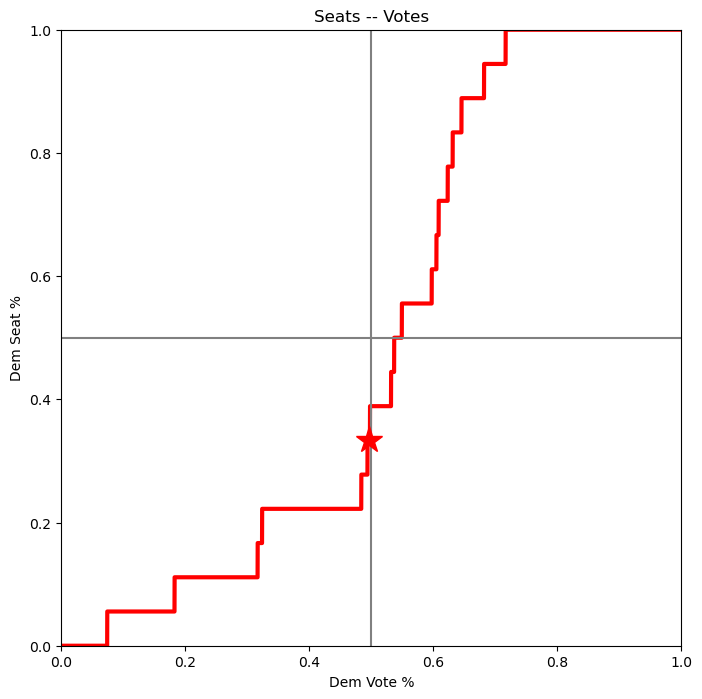

GOV


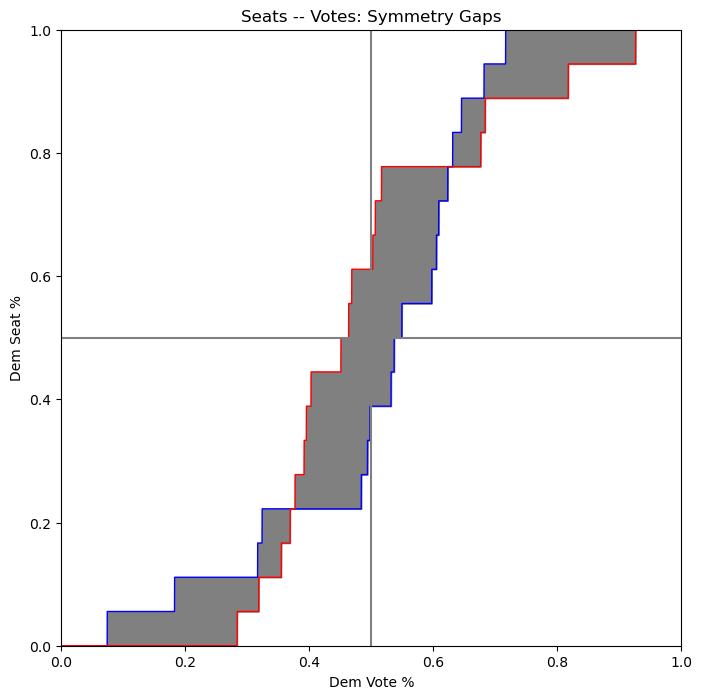

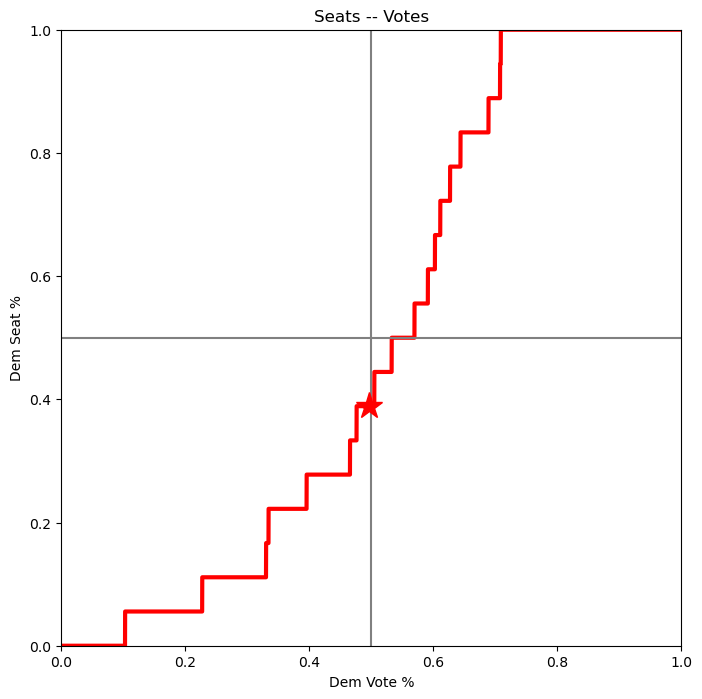

TS


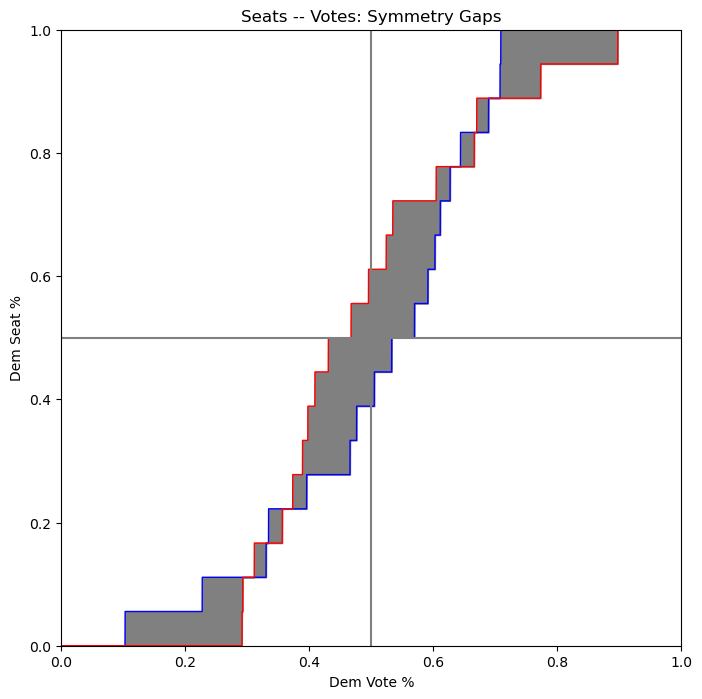

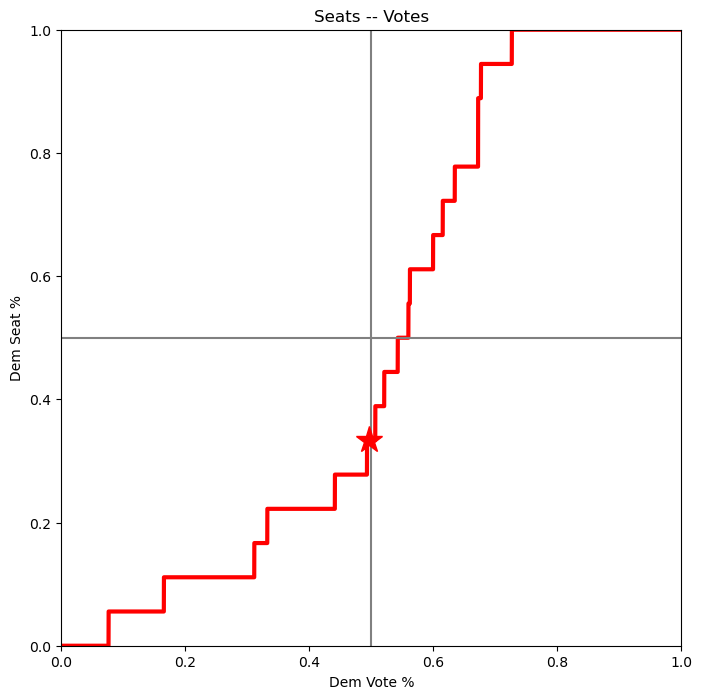

REMEDIAL


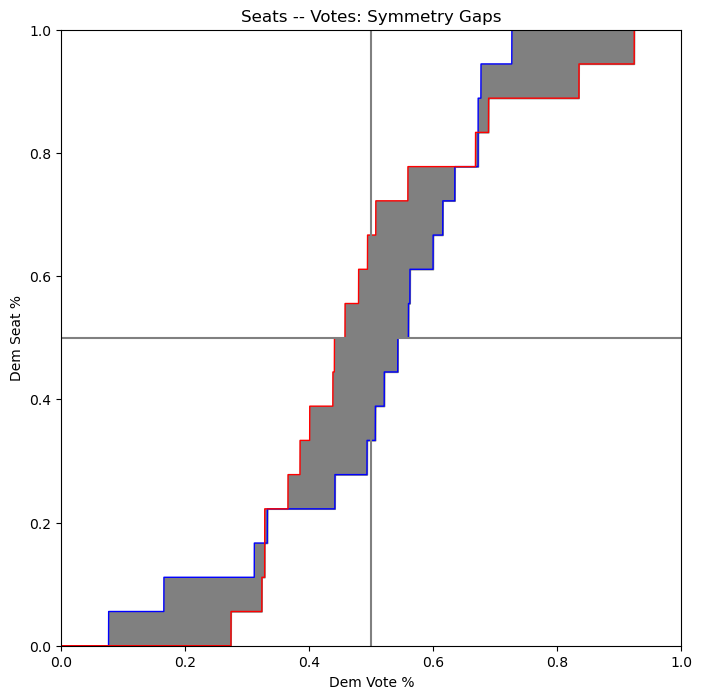

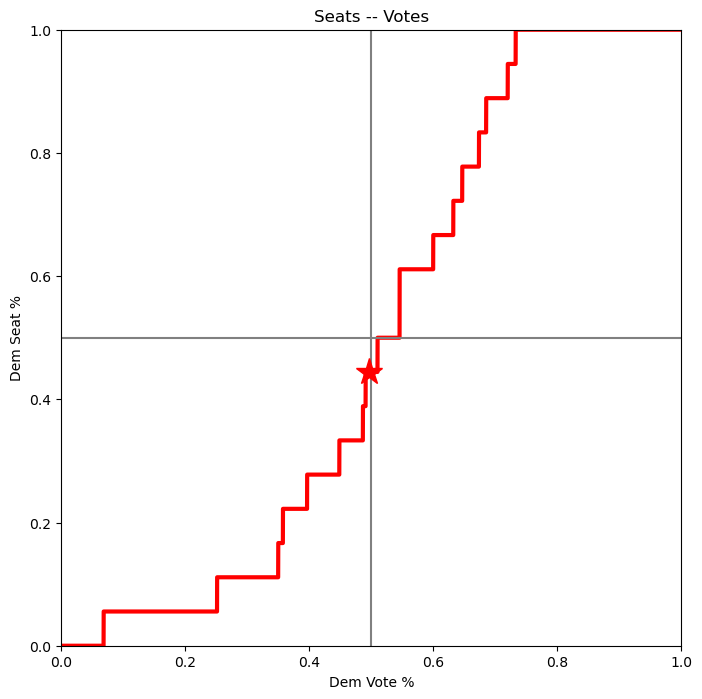

CPCT


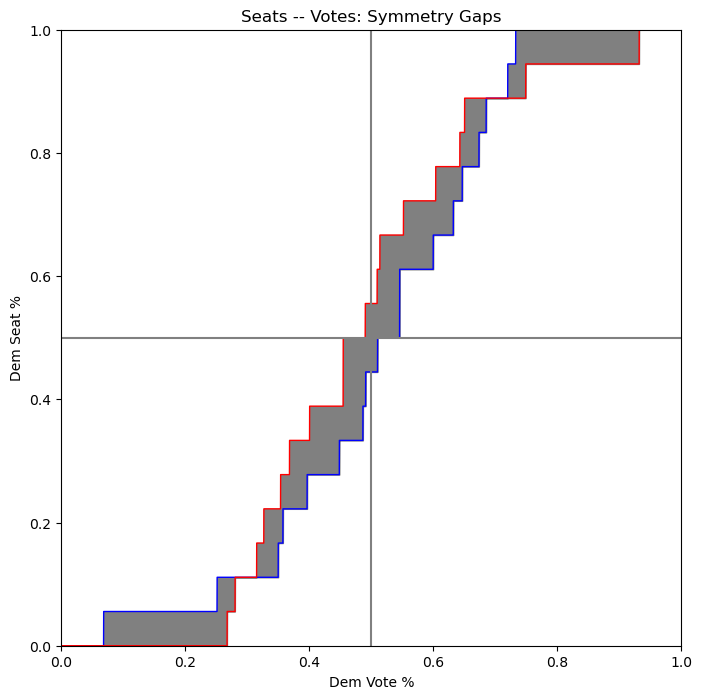

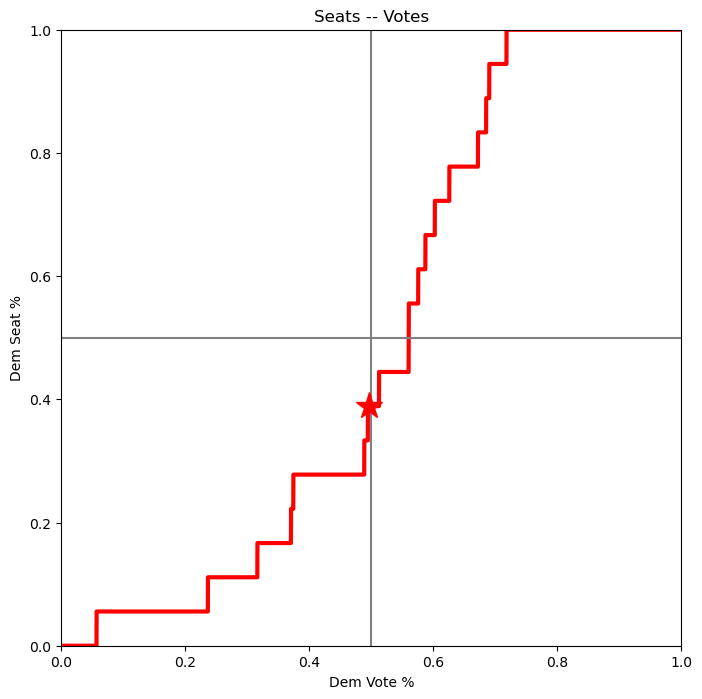

DEM


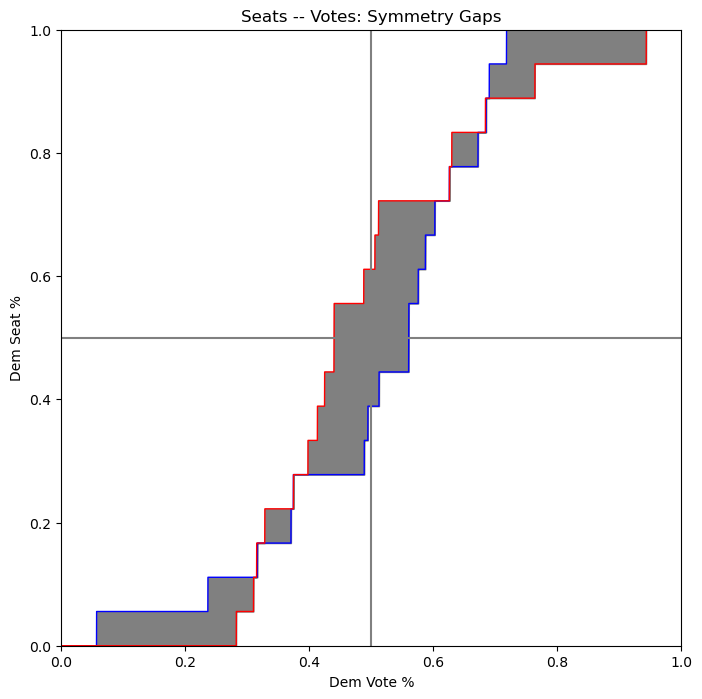

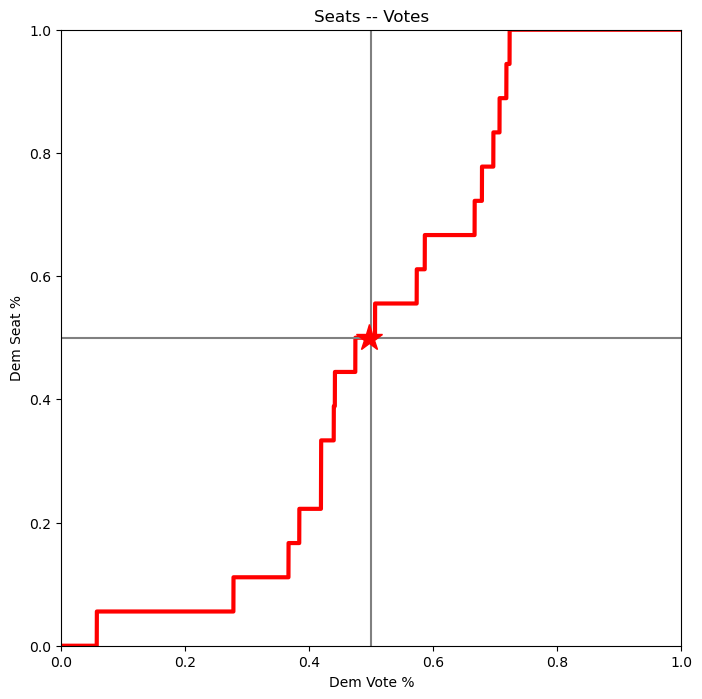

GOP


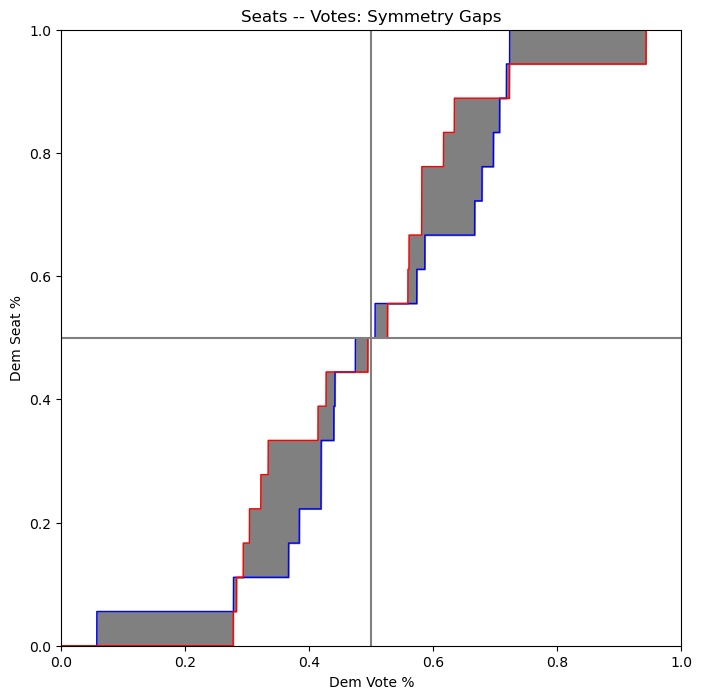

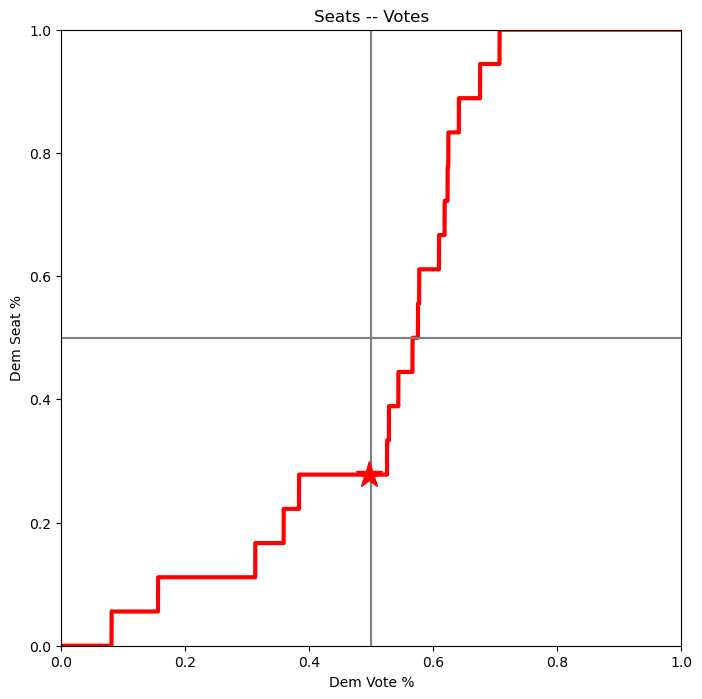

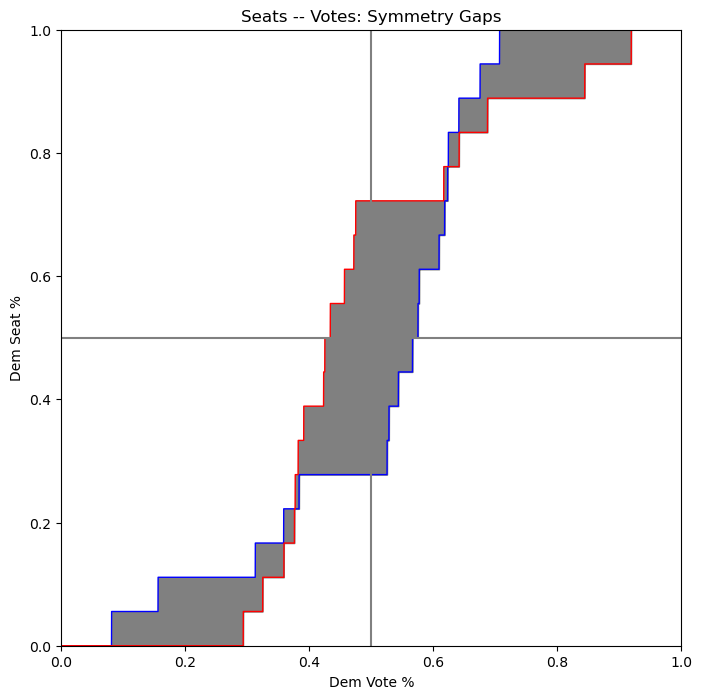

In [19]:
for i in range(n_base_plans):
    print(plan_part_labels[i])
    plot_symmetry_with_mean_overhaul_rb(sorted(plan_partitions[i]["PRES16"].percents("Democratic")),plan_partitions[i]["PRES16"].percent("Democratic"))


2011


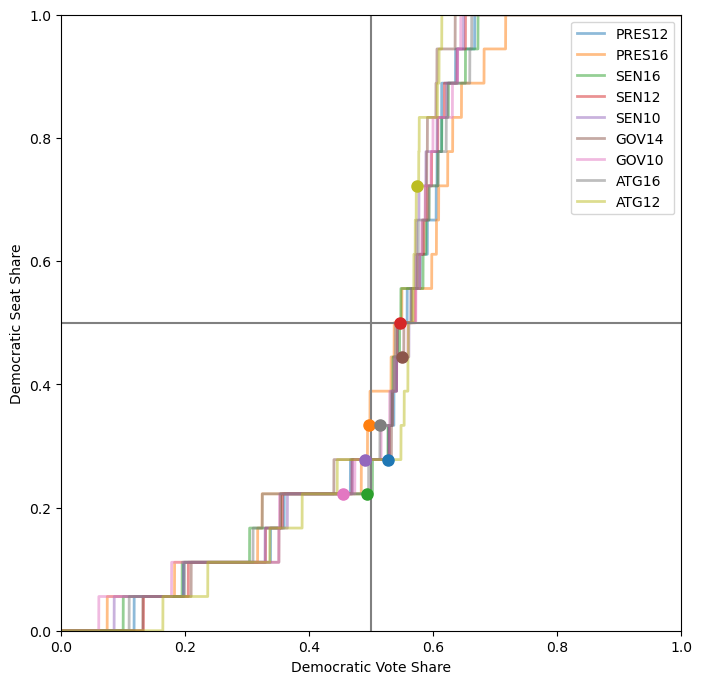

GOV


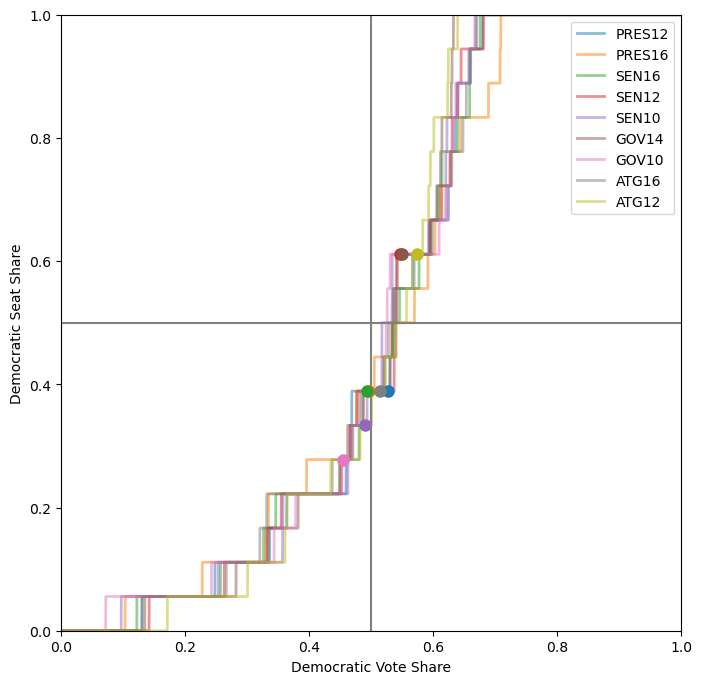

TS


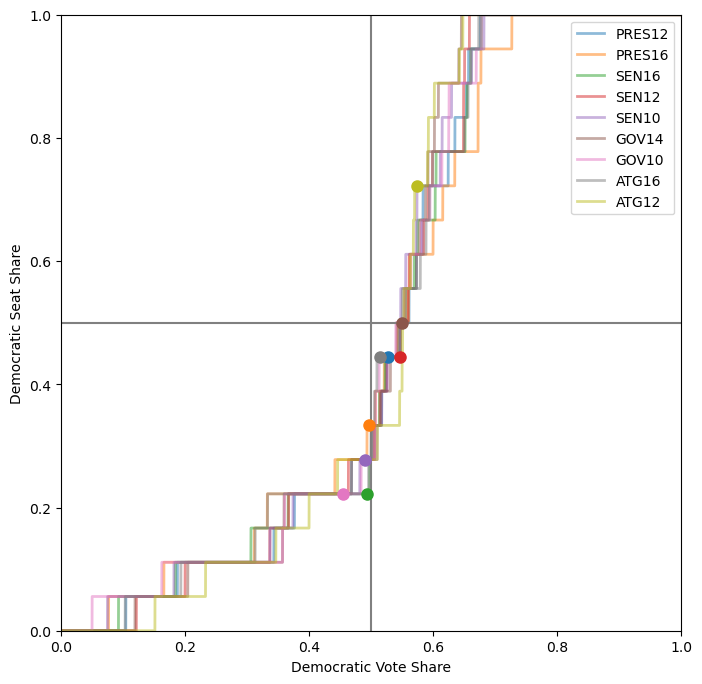

REMEDIAL


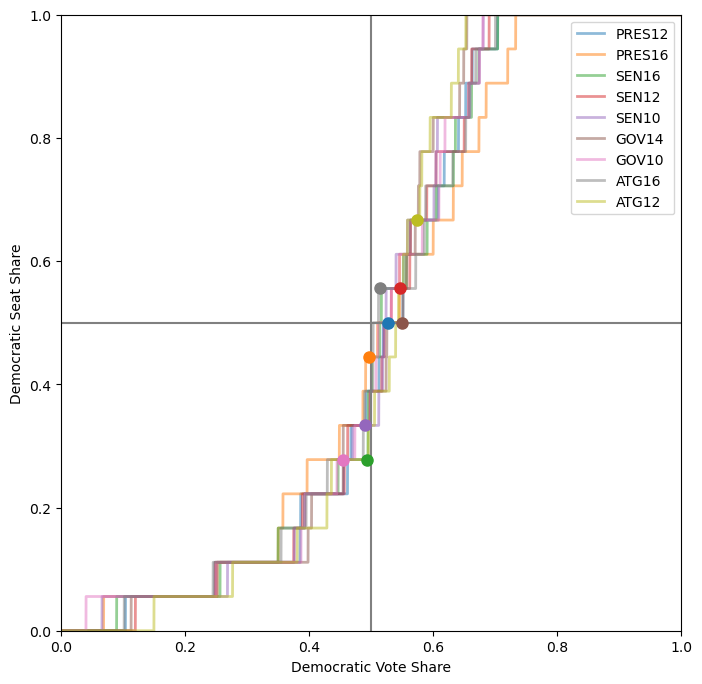

CPCT


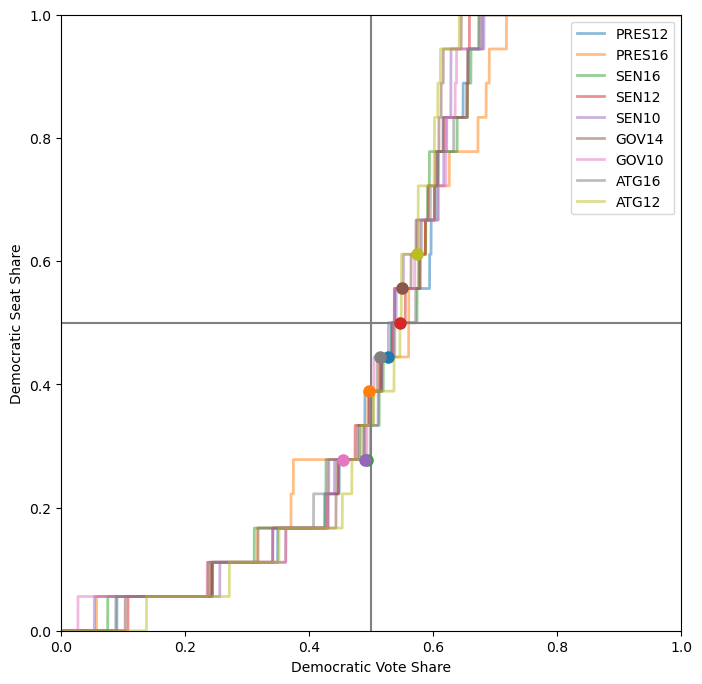

DEM


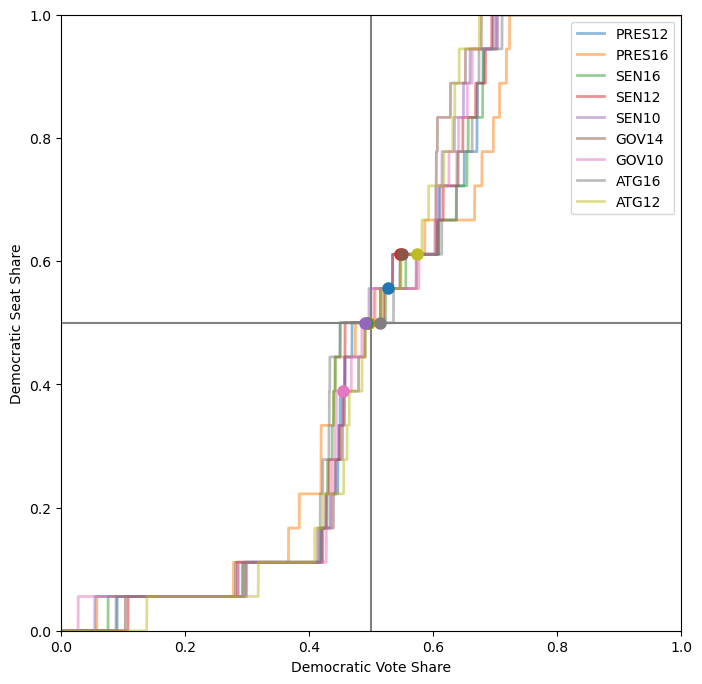

GOP


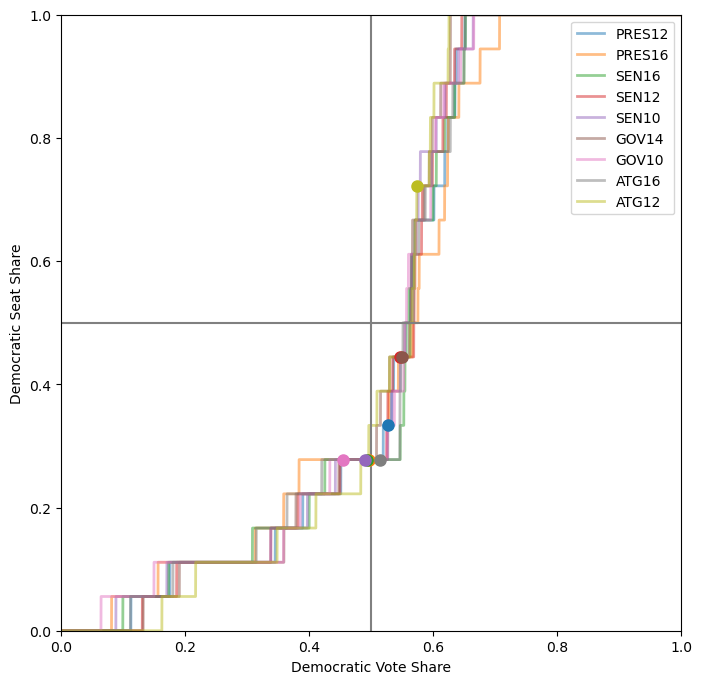

In [20]:
for i in range(n_base_plans):
    print(plan_part_labels[i])
    plot_lots_symmetry_notmean([sorted(plan_partitions[i][enames[elect]].percents("Democratic")) for elect in range(9)],[plan_partitions[i][enames[elect]].percent("Democratic") for elect in range(9)])


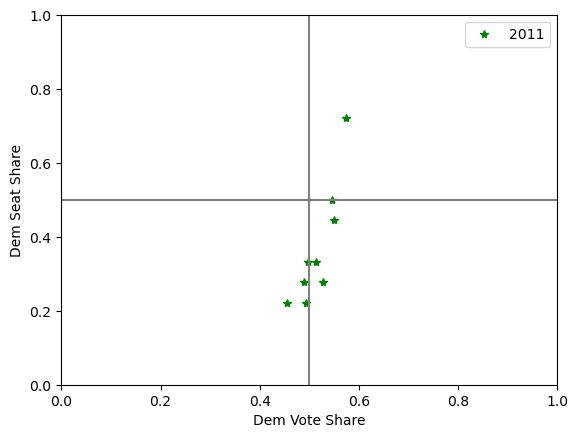

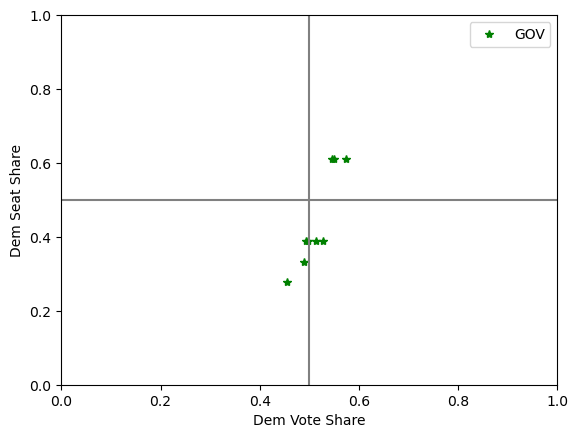

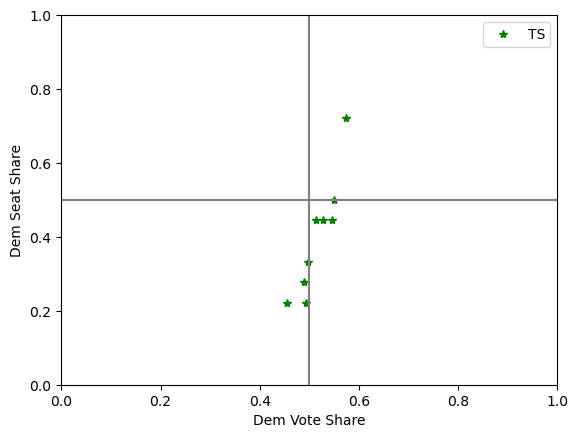

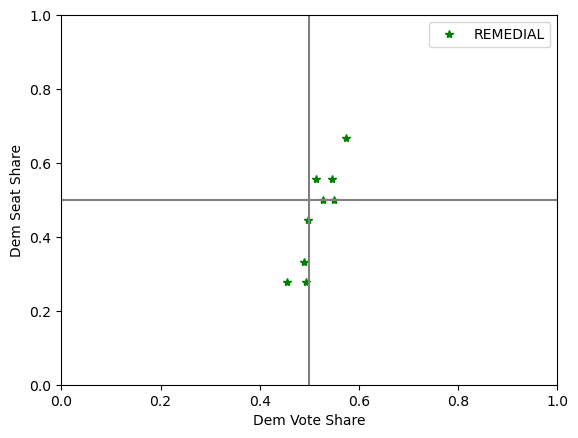

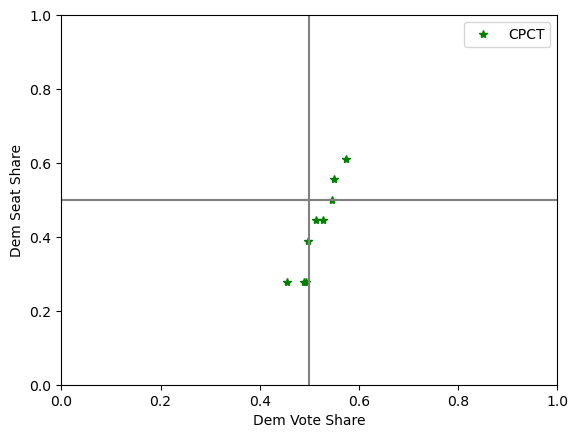

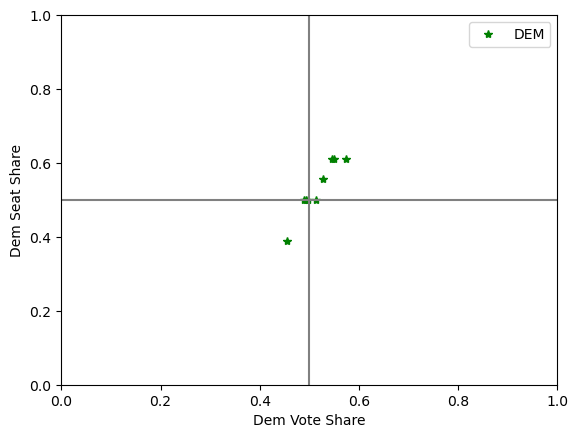

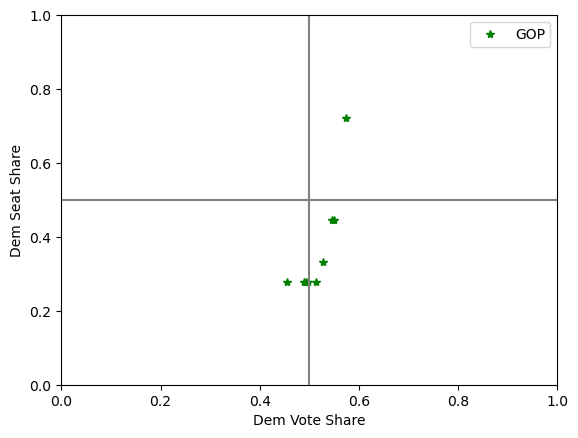

In [21]:
for i in range(n_base_plans):

    plt.plot(votes[i],[x/len(plan_partitions[i]) for x in wins[i]],'*',color='green',label=plan_part_labels[i])
    plt.axvline(x=.5,color='gray')
    plt.axhline(y=.5,color='gray')
    plt.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("Dem Vote Share")
    plt.ylabel("Dem Seat Share")
    plt.show()

In [22]:
heights = [1+x for x in range(n_base_plans)]


Text(0.5, 0, 'Efficiency Gap')

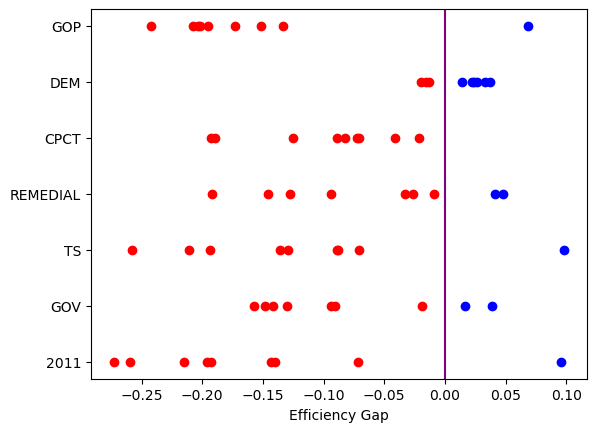

In [23]:
for i in range(n_base_plans):
    plt.plot([x for x in egs[i] if x<0],[heights[i] for x in range(len([x for x in egs[i] if x<0]))],'ro')
    plt.plot([x for x in egs[i] if x>0],[heights[i] for x in range(len([x for x in egs[i] if x>0]))],'bo')

plt.axvline(0,color='purple')
plt.yticks(heights,plan_part_labels)
plt.xlabel('Efficiency Gap')


Text(0.5, 0, 'Mean Median')

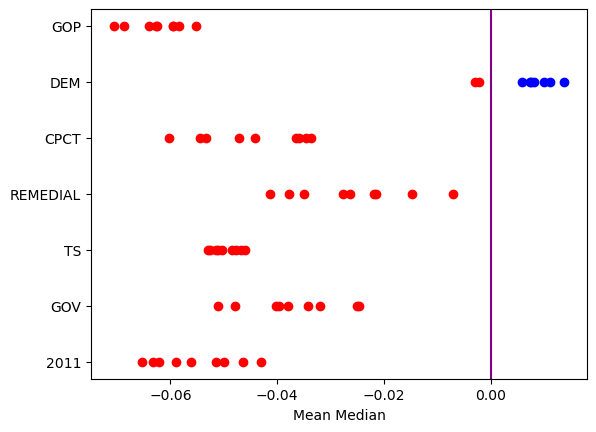

In [24]:
for i in range(n_base_plans):
    plt.plot([x for x in mms[i] if x<0],[heights[i] for x in range(len([x for x in mms[i] if x<0]))],'ro')
    plt.plot([x for x in mms[i] if x>0],[heights[i] for x in range(len([x for x in mms[i] if x>0]))],'bo')

plt.axvline(0,color='purple')
plt.yticks(heights,plan_part_labels)
plt.xlabel('Mean Median')


Text(0.5, 0, 'Partisan Bias')

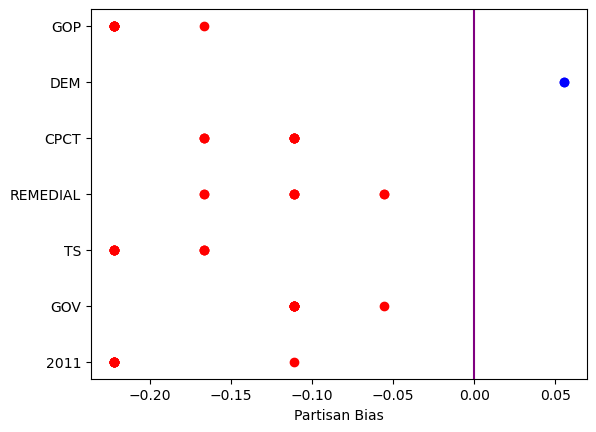

In [25]:
for i in range(n_base_plans):
    plt.plot([x for x in pbs[i] if x<0],[heights[i] for x in range(len([x for x in pbs[i] if x<0]))],'ro')
    plt.plot([x for x in pbs[i] if x>0],[heights[i] for x in range(len([x for x in pbs[i] if x>0]))],'bo')

plt.axvline(0,color='purple')
plt.yticks(heights,plan_part_labels)
plt.xlabel('Partisan Bias')


Text(0.5, 0, 'Declination')

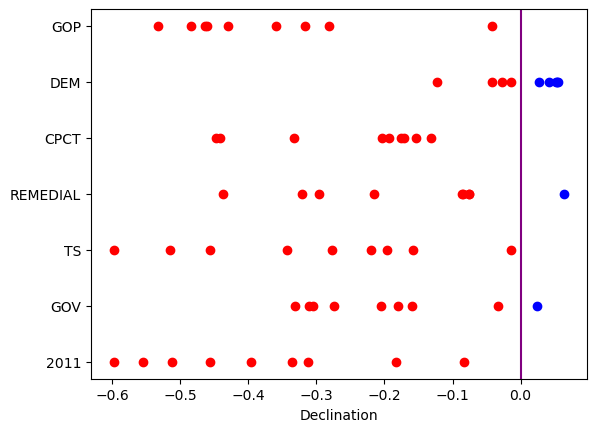

In [26]:
for i in range(n_base_plans):
    plt.plot([-x for x in decs[i] if x<0],[heights[i] for x in range(len([x for x in decs[i] if x<0]))],'bo')
    plt.plot([-x for x in decs[i] if x>0],[heights[i] for x in range(len([x for x in decs[i] if x>0]))],'ro')

plt.axvline(0,color='purple')
plt.yticks(heights,plan_part_labels)
plt.xlabel('Declination')


Text(0.5, 0, 'Lopsided Wins')

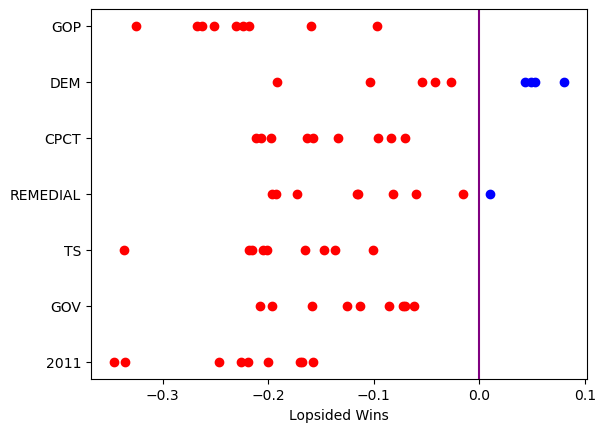

In [27]:
for i in range(n_base_plans):
    plt.plot([x for x in lws[i] if x<0],[heights[i] for x in range(len([x for x in lws[i] if x<0]))],'ro')
    plt.plot([x for x in lws[i] if x>0],[heights[i] for x in range(len([x for x in lws[i] if x>0]))],'bo')

plt.axvline(0,color='purple')
plt.yticks(heights,plan_part_labels)
plt.xlabel('Lopsided Wins')
